# Multivariate LSTM Time Series Stock Prediction - NASDAQ Comp

Stock Prediction of NASDAQ Comp using LSTM with multiple features.

**Data source:** Yahoo Finance via yfinance

**Features:** NASDAQ Comp Close, Close of 18 NASDAQ Comp components, Close of US Treasury Yield
>`NASDAQ_Comp_Close`, `Dow_Jones_Close`, `S_P_500_Close`, `AAPL_Close`,
               `MSFT_Close`, `AMZN_Close`, `FB_Close`, `GOOG_Close`, `GOOGL_Close`,
               `TSLA_Close`, `NVDA_Close`, `ASML_Close`, `INTC_Close`, `CMCSA_Close`,
               `NFLX_Close`, `ADBE_Close`, `CSCO_Close`, `PEP_Close`, `AVGO_Close`,
               `TXN_Close`, `TMUS_Close`, `_13_Week_Treasury_Bill_Close`,
               `Treasury_Yield_5_Years_Close`, `Treasury_Yield_10_Years_Close`,
               `Treasury_Yield_30_Years_Close`

**Train/Test:** 0.90 / 0.10

**Reference:** https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/#h-implementing-a-multivariate-time-series-prediction-model-in-python

### Setup

In [1]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training

# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 

import seaborn as sns

### Step #1 Load the Time Series Data via yfinance


In [2]:
# import pandas as pd
# import seaborn as sns
# import numpy as np
import random
import re
# import matplotlib.pyplot as plt
from datetime import date

plt.rcParams['figure.figsize'] = (20, 12) 
import yfinance as yf
pd.set_option('display.max_columns', 500)

In [3]:
def dpna(x):
    x.dropna(inplace=True)
    x.reset_index(drop=True,inplace=True)
    return x

def dr(x):
    drp=[]
    yes=[]
    #x['Open'].astype(float)
    for i in range(len(x['Open'])): 
            
        if i>0:
            drp.append((x['Open'][i]-x['Open'][i-1])/x['Open'][i-1]*100)
            if (x['Open'][i]-x['Open'][i-1])>0:
                yes.append(1)
            else:
                yes.append(0)
        else:
            drp.append(0)
            yes.append(np.nan)

    x['%_Daily_Return']=drp
    x['Yesterday_Price_Change']=yes  
        
    return x


def tr(x):
    dc=[]
    dcp=[]
    tmr=[]
    for i in range(len(x['Open'])): 
            
        if i!=(len(x['Open'])-1):
            dcp.append((x['Open'][i+1]-x['Open'][i])/x['Open'][i])
            if (x['Open'][i+1]-x['Open'][i])>0:
                dc.append(1)   
            else:
                dc.append(0)
            if (x['Close'][i+1]-x['Close'][i])>0:
                tmr.append(1)
            else:
                tmr.append(0)
                
        else:
            dcp.append(np.nan)
            dc.append(np.nan)
            tmr.append(np.nan)
        
    x['%_Daily_Change']=dcp
    x['Daily_Change']=dc
    x['tmr_Change']=tmr
        
        
    return x

In [17]:
# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")

In [19]:
#NASDAQ Composite (^IXIC), Dow Jones =DJI, S&P500=GSPC, 13 Week Treasury Bill (^IRX), Treasury Yield 5 Years (^FVX), Treasury Yield 10 Years (^TNX), Treasury Yield 30 Years (^TYX)

Index=['^IXIC','DJI','^GSPC']
Stock=['AAPL','MSFT','AMZN','FB','GOOG','GOOGL','TSLA','NVDA','ASML','INTC','CMCSA','NFLX','ADBE','CSCO','PEP','AVGO','TXN','TMUS']
Bond=['^IRX','^FVX','^TNX','^TYX']
Currency=['CNY=X','GBP=X','JPY=X','EUR=X','CAD=X']
col_list=Index+Stock+Bond+Currency

df=pd.DataFrame()

for i in col_list:
    data = yf.download(i, start="2013-01-01", end = date_today)
    data=dr(data)
    data=tr(data)
    col1_list=[i+'_'+j for j in data.columns]
    data.columns=col1_list
    data=data.loc[:, (data != 0.0).any(axis=0)]
    
    df=df=pd.DataFrame().join([df,data], how="outer")


#df.dropna(axis=0,inplace=True)
#df.reset_index(drop=True, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [20]:
df.reset_index(inplace=True)

In [21]:
df.Date=pd.to_datetime(df.Date)
df['DayOfWeek']=df['Date'].apply(lambda x:x.strftime('%w'))
df['Year']=df['Date'].apply(lambda x:x.strftime('%Y'))
df['Month']=df['Date'].apply(lambda x:x.strftime('%m'))

In [22]:
df.dropna(inplace=True)

In [23]:
df

,Date,^IXIC_Open,^IXIC_High,^IXIC_Low,^IXIC_Close,^IXIC_Adj Close,^IXIC_Volume,^IXIC_%_Daily_Return,^IXIC_Yesterday_Price_Change,^IXIC_%_Daily_Change,^IXIC_Daily_Change,^IXIC_tmr_Change,DJI_Open,DJI_High,DJI_Low,DJI_Close,DJI_Adj Close,DJI_Volume,DJI_%_Daily_Return,DJI_Yesterday_Price_Change,DJI_%_Daily_Change,DJI_Daily_Change,DJI_tmr_Change,^GSPC_Open,^GSPC_High,^GSPC_Low,^GSPC_Close,^GSPC_Adj Close,^GSPC_Volume,^GSPC_%_Daily_Return,^GSPC_Yesterday_Price_Change,^GSPC_%_Daily_Change,^GSPC_Daily_Change,^GSPC_tmr_Change,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,AAPL_%_Daily_Return,AAPL_Yesterday_Price_Change,AAPL_%_Daily_Change,AAPL_Daily_Change,AAPL_tmr_Change,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Adj Close,MSFT_Volume,MSFT_%_Daily_Return,MSFT_Yesterday_Price_Change,MSFT_%_Daily_Change,MSFT_Daily_Change,MSFT_tmr_Change,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Adj Close,AMZN_Volume,AMZN_%_Daily_Return,AMZN_Yesterday_Price_Change,AMZN_%_Daily_Change,AMZN_Daily_Change,AMZN_tmr_Change,FB_Open,FB_High,FB_Low,FB_Close,FB_Adj Close,FB_Volume,FB_%_Daily_Return,FB_Yesterday_Price_Change,FB_%_Daily_Change,FB_Daily_Change,FB_tmr_Change,GOOG_Open,GOOG_High,GOOG_Low,GOOG_Close,GOOG_Adj Close,GOOG_Volume,GOOG_%_Daily_Return,GOOG_Yesterday_Price_Change,GOOG_%_Daily_Change,GOOG_Daily_Change,GOOG_tmr_Change,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Adj Close,GOOGL_Volume,GOOGL_%_Daily_Return,GOOGL_Yesterday_Price_Change,GOOGL_%_Daily_Change,GOOGL_Daily_Change,GOOGL_tmr_Change,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_Adj Close,TSLA_Volume,TSLA_%_Daily_Return,TSLA_Yesterday_Price_Change,TSLA_%_Daily_Change,TSLA_Daily_Change,TSLA_tmr_Change,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Adj Close,NVDA_Volume,NVDA_%_Daily_Return,NVDA_Yesterday_Price_Change,NVDA_%_Daily_Change,NVDA_Daily_Change,NVDA_tmr_Change,ASML_Open,ASML_High,ASML_Low,ASML_Close,ASML_Adj Close,ASML_Volume,ASML_%_Daily_Return,ASML_Yesterday_Price_Change,ASML_%_Daily_Change,ASML_Daily_Change,ASML_tmr_Change,INTC_Open,INTC_High,INTC_Low,INTC_Close,INTC_Adj Close,INTC_Volume,INTC_%_Daily_Return,INTC_Yesterday_Price_Change,INTC_%_Daily_Change,INTC_Daily_Change,INTC_tmr_Change,CMCSA_Open,CMCSA_High,CMCSA_Low,CMCSA_Close,CMCSA_Adj Close,CMCSA_Volume,CMCSA_%_Daily_Return,CMCSA_Yesterday_Price_Change,CMCSA_%_Daily_Change,CMCSA_Daily_Change,CMCSA_tmr_Change,NFLX_Open,NFLX_High,NFLX_Low,NFLX_Close,NFLX_Adj Close,NFLX_Volume,NFLX_%_Daily_Return,NFLX_Yesterday_Price_Change,NFLX_%_Daily_Change,NFLX_Daily_Change,NFLX_tmr_Change,ADBE_Open,ADBE_High,ADBE_Low,ADBE_Close,ADBE_Adj Close,ADBE_Volume,ADBE_%_Daily_Return,ADBE_Yesterday_Price_Change,ADBE_%_Daily_Change,ADBE_Daily_Change,ADBE_tmr_Change,CSCO_Open,CSCO_High,CSCO_Low,CSCO_Close,CSCO_Adj Close,CSCO_Volume,CSCO_%_Daily_Return,CSCO_Yesterday_Price_Change,CSCO_%_Daily_Change,CSCO_Daily_Change,CSCO_tmr_Change,PEP_Open,PEP_High,PEP_Low,PEP_Close,PEP_Adj Close,PEP_Volume,PEP_%_Daily_Return,PEP_Yesterday_Price_Change,PEP_%_Daily_Change,PEP_Daily_Change,PEP_tmr_Change,AVGO_Open,AVGO_High,AVGO_Low,AVGO_Close,AVGO_Adj Close,AVGO_Volume,AVGO_%_Daily_Return,AVGO_Yesterday_Price_Change,AVGO_%_Daily_Change,AVGO_Daily_Change,AVGO_tmr_Change,TXN_Open,TXN_High,TXN_Low,TXN_Close,TXN_Adj Close,TXN_Volume,TXN_%_Daily_Return,TXN_Yesterday_Price_Change,TXN_%_Daily_Change,TXN_Daily_Change,TXN_tmr_Change,TMUS_Open,TMUS_High,TMUS_Low,TMUS_Close,TMUS_Adj Close,TMUS_Volume,TMUS_%_Daily_Return,TMUS_Yesterday_Price_Change,TMUS_%_Daily_Change,TMUS_Daily_Change,TMUS_tmr_Change,^IRX_Open,^IRX_High,^IRX_Low,^IRX_Close,^IRX_Adj Close,^IRX_%_Daily_Return,^IRX_Yesterday_Price_Change,^IRX_%_Daily_Change,^IRX_Daily_Change,^IRX_tmr_Change,^FVX_Open,^FVX_High,^FVX_Low,^FVX_Close,^FVX_Adj Close,^FVX_%_Daily_Return,^FVX_Yesterday_Price_Change,^FVX_%_Daily_Change,^FVX_Daily_Change,^FVX_tmr_Change,^TNX_Open,^TNX_High,^TNX_Low,^TNX_Close,^TNX_Adj Close,^TNX_%_Daily_Return,^TNX_Yesterday_Price_Change,^TNX_%_Daily_Change,^TNX_Daily_Change,^

In [ ]:
df.info(verbose=True,null_counts=True)

In [9]:
Close = pd.concat([df.filter(items=['Date']), df.filter(regex=r'\_Close$', axis=1)], axis=1)
Close = Close.set_index("Date")
Close = Close.drop(columns = ['CNY=X_Close','GBP=X_Close','JPY=X_Close','EUR=X_Close','CAD=X_Close'])
Close.head()

,^IXIC_Close,DJI_Close,^GSPC_Close,AAPL_Close,MSFT_Close,AMZN_Close,FB_Close,GOOG_Close,GOOGL_Close,TSLA_Close,NVDA_Close,ASML_Close,INTC_Close,CMCSA_Close,NFLX_Close,ADBE_Close,CSCO_Close,PEP_Close,AVGO_Close,TXN_Close,TMUS_Close,^IRX_Close,^FVX_Close,^TNX_Close,^TYX_Close
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,3112.260010,13412.500000,1462.420044,19.608213,27.620001,257.309998,28.000000,360.274597,361.987000,7.072,3.1800,66.779999,21.379999,19.260000,13.144286,38.340000,20.340000,69.330002,32.540001,32.310001,19.400000,0.055,0.763,1.839,3.046
2013-01-03,3100.570068,13391.400391,1459.369995,19.360714,27.250000,258.480011,27.770000,360.483826,362.197205,6.954,3.1825,65.379997,21.320000,19.045000,13.798571,37.750000,20.450001,69.360001,32.709999,31.889999,19.260000,0.065,0.808,1.899,3.107
2013-01-04,3101.659912,13435.200195,1466.469971,18.821428,26.740000,259.149994,28.760000,367.607117,369.354340,6.880,3.2875,64.709999,21.160000,19.035000,13.711429,38.130001,20.480000,69.459999,32.500000,31.820000,19.459999,0.065,0.819,1.915,3.111
2013-01-07,3098.810059,13384.299805,1461.890015,18.710714,26.690001,268.459991,29.420000,366.003143,367.742737,6.868,3.1925,63.660000,21.250000,18.950001,14.171429,37.939999,20.290001,69.449997,32.320000,31.920000,19.120001,0.058,0.813,1.903,3.100
2013-01-08,3091.810059,13328.799805,1457.150024,18.761070,26.549999,266.380005,29.059999,365.280823,367.017029,6.736,3.1225,63.139999,21.090000,19.080000,13.880000,38.139999,20.309999,69.660004,32.099998,31.549999,18.660000,0.060,0.785,1.871,3.071


### Step #2 Explore the Data


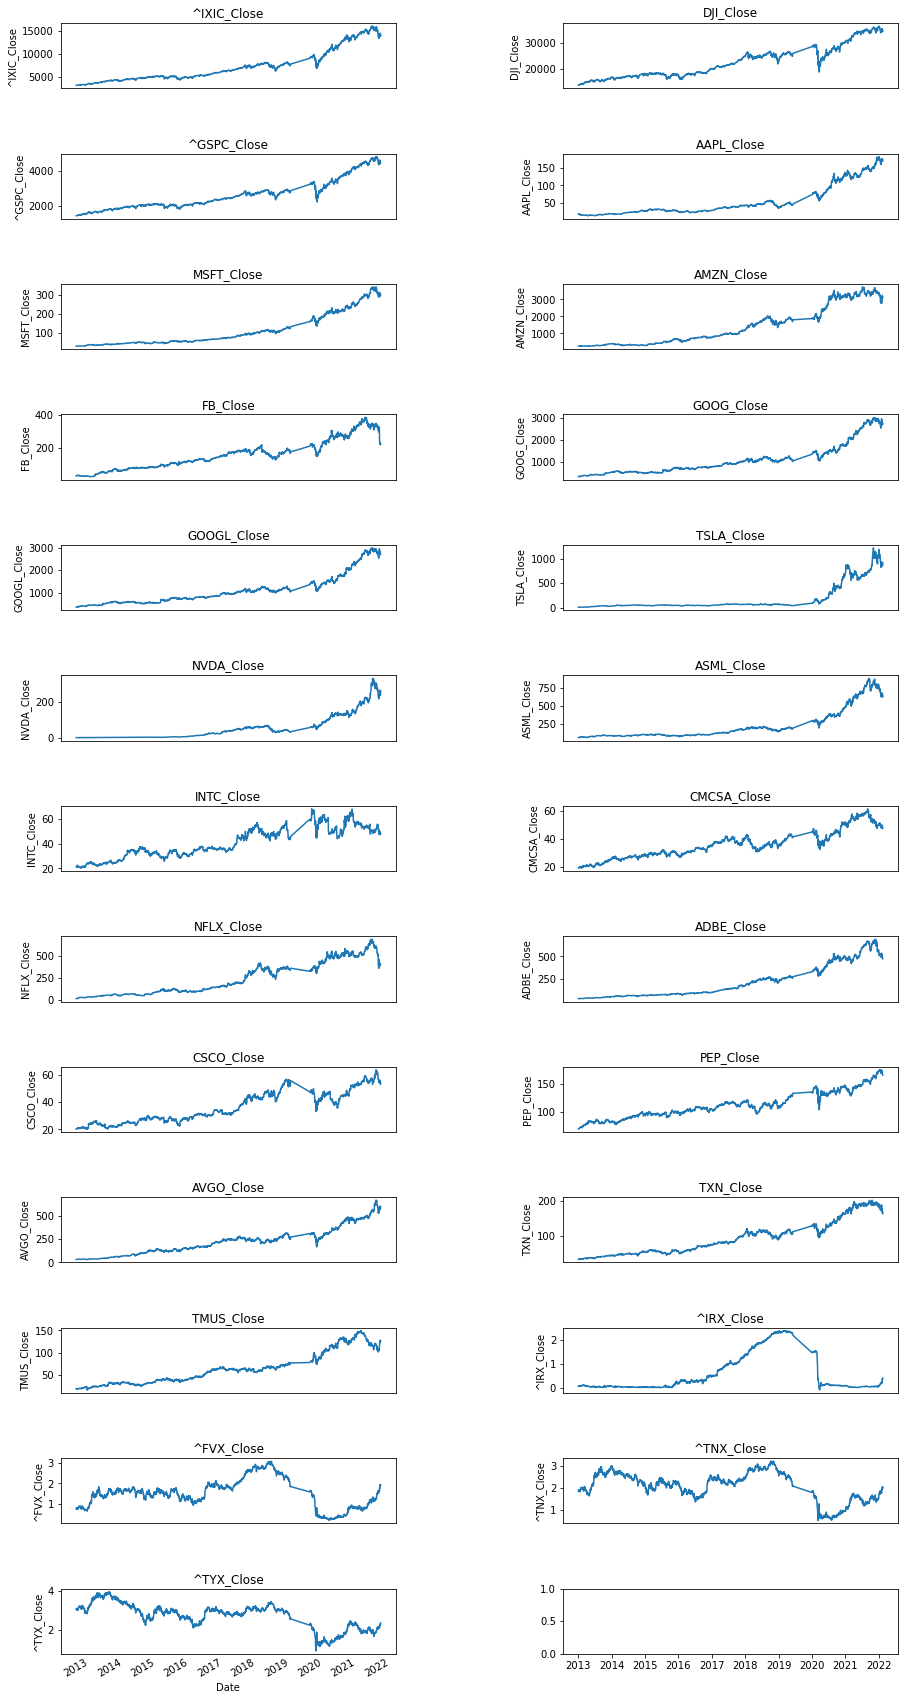

In [25]:
# Plot line charts
Close_plot = Close.copy()

list_length = Close_plot.shape[1]
ncols = 2
nrows = int(round(list_length // ncols +1, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 30))
fig.subplots_adjust(hspace=1, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = Close.iloc[:, i], ax=ax)
        ax.set_title(Close.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
# fig.tight_layout()
plt.show()

### Step #3 Scaling and Feature Selection

In [12]:
# Indexing Batches
train_df = Close.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Month'] = d.strftime("%m")
train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,^IXIC_Close,DJI_Close,^GSPC_Close,AAPL_Close,MSFT_Close,AMZN_Close,FB_Close,GOOG_Close,GOOGL_Close,TSLA_Close,NVDA_Close,ASML_Close,INTC_Close,CMCSA_Close,NFLX_Close,ADBE_Close,CSCO_Close,PEP_Close,AVGO_Close,TXN_Close,TMUS_Close,^IRX_Close,^FVX_Close,^TNX_Close,^TYX_Close,Month,Year
0,3112.260010,13412.500000,1462.420044,19.608213,27.620001,257.309998,28.000000,360.274597,361.987000,7.072,3.1800,66.779999,21.379999,19.260000,13.144286,38.340000,20.340000,69.330002,32.540001,32.310001,19.400000,0.055,0.763,1.839,3.046,01,2013
1,3100.570068,13391.400391,1459.369995,19.360714,27.250000,258.480011,27.770000,360.483826,362.197205,6.954,3.1825,65.379997,21.320000,19.045000,13.798571,37.750000,20.450001,69.360001,32.709999,31.889999,19.260000,0.065,0.808,1.899,3.107,01,2013
2,3101.659912,13435.200195,1466.469971,18.821428,26.740000,259.149994,28.760000,367.607117,369.354340,6.880,3.2875,64.709999,21.160000,19.035000,13.711429,38.130001,20.480000,69.459999,32.500000,31.820000,19.459999,0.065,0.819,1.915,3.111,01,2013
3,3098.810059,13384.299805,1461.890015,18.710714,26.690001,268.459991,29.420000,366.003143,367.742737,6.868,3.1925,63.660000,21.250000,18.950001,14.171429,37.939999,20.290001,69.449997,32.320000,31.920000,19.120001,0.058,0.813,1.903,3.100,01,2013
4,3091.810059,13328.799805,1457.150024,18.761070,26.549999,266.380005,29.059999,365.280823,367.017029,6.736,3.1225,63.139999,21.090000,19.080000,13.880000,38.139999,20.309999,69.660004,32.099998,31.549999,18.660000,0.060,0.785,1.871,3.071,01,2013


In [13]:
train_df.columns

Index(['^IXIC_Close', 'DJI_Close', '^GSPC_Close', 'AAPL_Close', 'MSFT_Close',
       'AMZN_Close', 'FB_Close', 'GOOG_Close', 'GOOGL_Close', 'TSLA_Close',
       'NVDA_Close', 'ASML_Close', 'INTC_Close', 'CMCSA_Close', 'NFLX_Close',
       'ADBE_Close', 'CSCO_Close', 'PEP_Close', 'AVGO_Close', 'TXN_Close',
       'TMUS_Close', '^IRX_Close', '^FVX_Close', '^TNX_Close', '^TYX_Close',
       'Month', 'Year'],
      dtype='object')

In [14]:
# List of considered Features
FEATURES = ['^IXIC_Close', '^DJI_Close', '^GSPC_Close', 'AAPL_Close', 'MSFT_Close',
       'AMZN_Close', 'FB_Close', 'GOOG_Close', 'GOOGL_Close', 'TSLA_Close',
       'NVDA_Close', 'ASML_Close', 'INTC_Close', 'CMCSA_Close', 'NFLX_Close',
       'ADBE_Close', 'CSCO_Close', 'PEP_Close', 'AVGO_Close', 'TXN_Close',
       'TMUS_Close', '^IRX_Close', '^FVX_Close', '^TNX_Close', '^TYX_Close']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['^IXIC_Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['^IXIC_Close', 'DJI_Close', '^GSPC_Close', 'AAPL_Close', 'MSFT_Close', 'AMZN_Close', 'FB_Close', 'GOOG_Close', 'GOOGL_Close', 'TSLA_Close', 'NVDA_Close', 'ASML_Close', 'INTC_Close', 'CMCSA_Close', 'NFLX_Close', 'ADBE_Close', 'CSCO_Close', 'PEP_Close', 'AVGO_Close', 'TXN_Close', 'TMUS_Close', '^IRX_Close', '^FVX_Close', '^TNX_Close', '^TYX_Close']


,^IXIC_Close,DJI_Close,^GSPC_Close,AAPL_Close,MSFT_Close,AMZN_Close,FB_Close,GOOG_Close,GOOGL_Close,TSLA_Close,NVDA_Close,ASML_Close,INTC_Close,CMCSA_Close,NFLX_Close,ADBE_Close,CSCO_Close,PEP_Close,AVGO_Close,TXN_Close,TMUS_Close,^IRX_Close,^FVX_Close,^TNX_Close,^TYX_Close,Prediction
2115,14490.370117,35768.101562,4587.180176,176.279999,311.209991,3223.790039,232.000000,2829.060059,2831.840088,932.000000,267.049988,680.369995,49.910000,49.770000,412.890015,521.750000,56.290001,171.940002,611.340027,176.710007,128.080002,0.270,1.802,1.929,2.232,14490.370117
2116,14185.639648,35241.601562,4504.080078,172.119995,302.380005,3180.070068,228.070007,2772.050049,2772.399902,904.549988,258.239990,656.880005,48.860001,48.919998,406.269989,495.019989,54.869999,168.369995,591.359985,170.660004,125.129997,0.370,1.944,2.031,2.309,14185.639648
2117,13791.150391,34738.101562,4418.640137,168.639999,295.040009,3065.870117,219.550003,2682.600098,2685.649902,860.000000,239.490005,628.239990,47.630001,47.619999,391.309998,473.970001,53.900002,168.580002,573.419983,164.399994,124.480003,0.338,1.868,1.955,2.257,13791.150391
2118,13790.919922,34566.199219,4401.669922,168.880005,295.000000,3103.340088,217.699997,2706.000000,2710.520020,875.760010,242.669998,627.909973,47.580002,47.400002,396.570007,474.010010,53.180000,166.699997,578.580017,162.470001,125.510002,0.360,1.918,1.996,2.301,13790.919922
2119,14139.759766,34988.800781,4471.069824,172.789993,300.470001,3130.209961,221.000000,2728.510010,2732.169922,922.429993,264.950012,656.409973,48.439999,48.049999,407.459991,479.500000,54.270000,165.960007,602.770020,166.169998,127.029999,0.400,1.935,2.045,2.362,14139.759766


In [16]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['^IXIC_Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2120, 25)


### Step #4 Transforming the Data

In [10]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

In [11]:
# Prediction Index
index_Close = data.columns.get_loc('^IXIC_Close')

In [12]:
# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 90% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.9)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1991, 50, 25) (1991,)
(226, 50, 25) (226,)
0.023346366150605702
0.023346366150605702


### Step #5 Train the Multivariate Prediction Model

In [13]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

2022-02-19 07:02:31.926585: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1250 50 25


In [14]:
# Training the model
epochs = 10
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),

                    callbacks=[early_stop])

Epoch 1/10
125/125 [==============================] - 738s 6s/step - loss: 0.2593 - val_loss: 0.0096
Epoch 2/10
125/125 [==============================] - 711s 6s/step - loss: 2.1705e-04 - val_loss: 0.0039
Epoch 3/10
125/125 [==============================] - 583s 5s/step - loss: 1.8739e-04 - val_loss: 0.0024
Epoch 4/10
125/125 [==============================] - 1433s 12s/step - loss: 1.7449e-04 - val_loss: 0.0011
Epoch 5/10
125/125 [==============================] - 1183s 9s/step - loss: 1.7767e-04 - val_loss: 0.0013
Epoch 6/10
125/125 [==============================] - 741s 6s/step - loss: 1.6329e-04 - val_loss: 0.0021
Epoch 7/10
125/125 [==============================] - 619s 5s/step - loss: 1.7591e-04 - val_loss: 8.8877e-04
Epoch 8/10
125/125 [==============================] - 579s 5s/step - loss: 1.5261e-04 - val_loss: 0.0017
Epoch 9/10
125/125 [==============================] - 577s 5s/step - loss: 1.5900e-04 - val_loss: 8.0283e-04
Epoch 10/10
125/125 [===========================

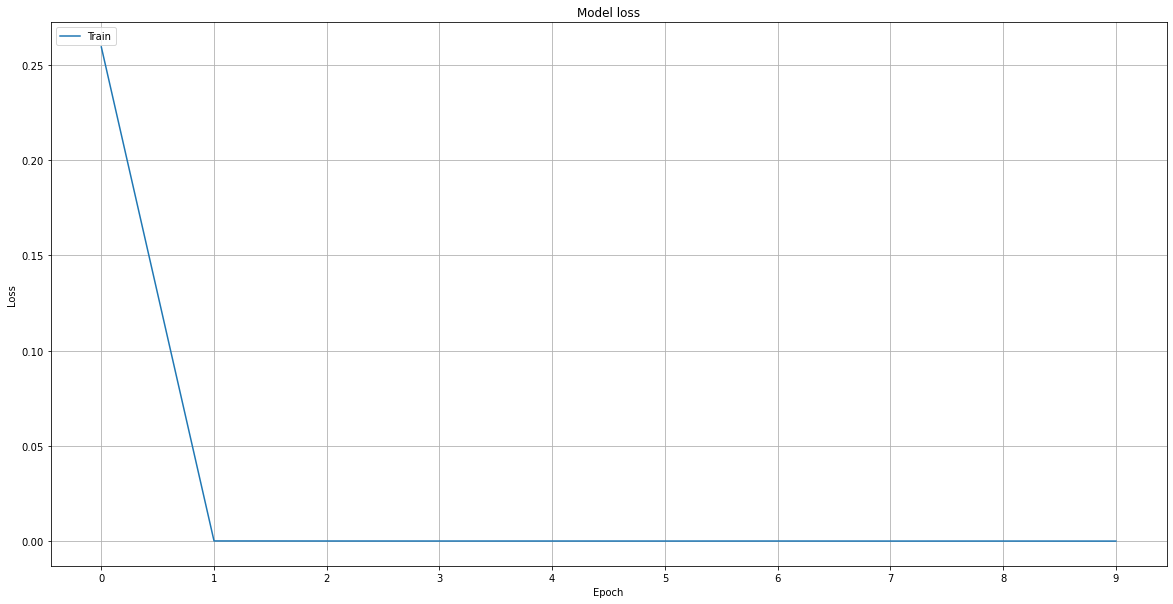

In [15]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

### Step #6 Evaluate Model Performance

In [16]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 300.41
Mean Absolute Percentage Error (MAPE): 2.35 %
Median Absolute Percentage Error (MDAPE): 2.05 %


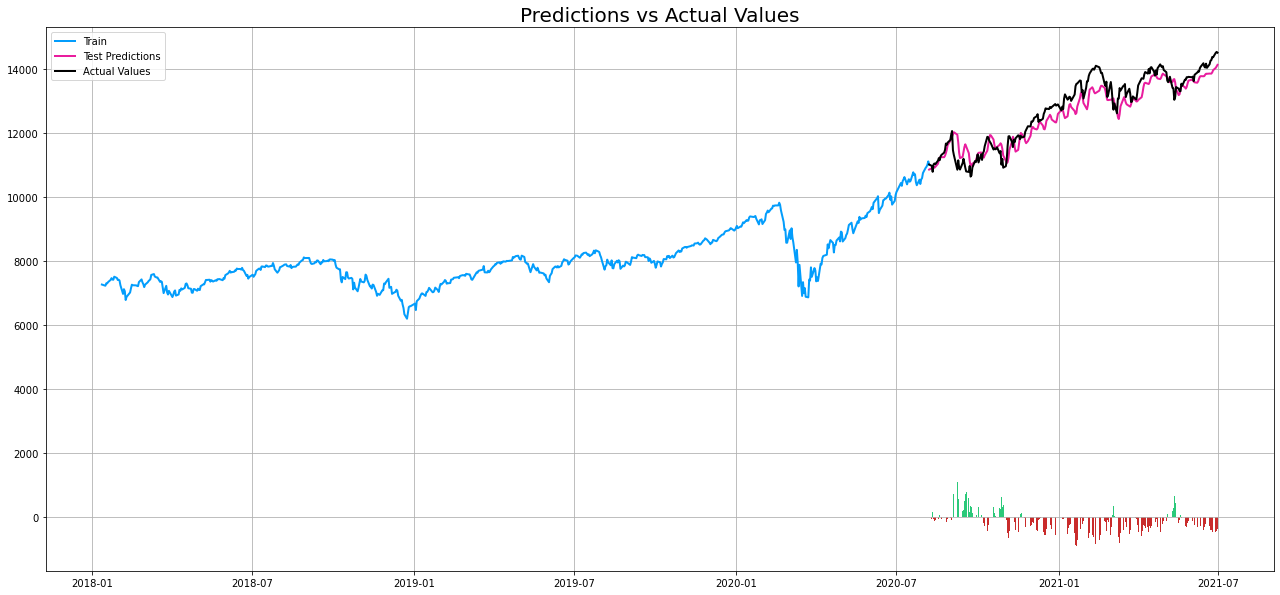

In [17]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=1500)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid['^IXIC_Close'], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[['^IXIC_Close']]
xv = valid['Date']; yv = valid[['^IXIC_Close', "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
#plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv['^IXIC_Close'], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

In [ ]:
df_temp = Close[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['^IXIC_Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')